In [73]:
import pandas as pd
import ast
from scipy.stats import norm
import numpy as np

# Abstract level CT annotation and evaluation

In [260]:
!pip install abbreviations

DEPRECATION: prodigy 1.11.8 has a non-standard dependency specifier srsly>=2.0.0<3.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of prodigy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [261]:
import pandas as pd
from abbreviations import schwartz_hearst

In [262]:
pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text='The emergency room (ER) was busy')
pairs

{'ER': 'emergency room'}

In [263]:
annotated_files_path_prefix = "./predictions/"

## Evaluation Scripts

In [551]:
def exact_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for target_string in target:
        if target_string in prediction:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        if prediction_string not in target:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = exact_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [552]:
def majority_rule_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for target_string in target:
        target_words = target_string.split()
        matching_count = 0

        for prediction_string in prediction:
            prediction_words = prediction_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count > 0:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        prediction_words = prediction_string.split()
        matching_count = 0

        for target_string in target:
            target_words = target_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count == 0:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = majority_rule_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)


True Positives: 2
False Positives: 0
False Negatives: 0


In [553]:
def f1_score(precision, recall):
    if precision > 0 or recall > 0:
        f1 = 2 * ((precision * recall) / (precision + recall))
    else:
        f1 = 0
    return f1

def calculate_precision_recall_v2(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"p": 0, "r": 0, "f1": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
    #print(tp,fp,fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = f1_score(precision, recall)
 
    return {"p":round(precision,2), "r":round(recall,2), "f1":round(f1,2)}

def calculate_tp_fp_fn(prediction, target, method="exact_match", threshold=None):
    # FUNCTION ASSUMES EMPTY VALUES WERE REPLACED WITH EMPTY STRING! df_eval[col_to_eval].fillna('')
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"tp": 0, "fp": 0, "fn": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
 
    return {"tp":round(tp,2), "fp":round(fp,2), "fn":round(fn,2)}

In [ ]:
def wilson_score_interval(tp, fp, fn, metric):
    confidence=0.95
    x = tp
    if metric == "precision":
        n = tp + fp
    elif metric == "recall":
        n = tp + fn
    elif metric == "f1":
        x = 2 * tp
        n = 2 * tp + fp + fn
    else:
        return (0, 0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = x / n
    center = (x + z ** 2 / 2) / (n + z ** 2)

    interval = ((z * np.sqrt(n)) / (n + z ** 2)) * np.sqrt(phat * (1 - phat) + z ** 2 / (4 * n))

    lower_bound = center - interval
    upper_bound = center + interval
    
    if phat == 0:
        return (0,0,0)
    
    return round(lower_bound,3), round(phat,3), round(upper_bound,3)

## Load annotations and Target Test Set

In [264]:
hugging_face_model_name_biolink = "michiyasunaga/BioLinkBERT-base"
model_name_str_biolink = hugging_face_model_name_biolink.split("/")[1]

In [265]:
hugging_face_model_name_biobert = "dmis-lab/biobert-v1.1"
model_name_str_biobert = hugging_face_model_name_biobert.split("/")[1]

In [266]:
hugging_face_model_name_bertbase = "bert-base-uncased"
model_name_str_bertbase = "bert-base-uncased"

In [267]:
# read annotated target dataset 
ds_annotated_full = pd.read_csv("../data/annotated_data/data_splits/ct_neuro_test_merged_90.csv")
col_name_target_annot = "ner_manual_ct_target"
# select only relevant columns
df = ds_annotated_full[['nct_id', 'text', col_name_target_annot]]

In [268]:
biolinkbert_col = f'ner_prediction_{model_name_str_biolink}_normalized'
df_biolinkbert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biolink}_20230916.csv")[['nct_id', biolinkbert_col]]
df = pd.merge(df, df_biolinkbert, on='nct_id', how='left')

In [269]:
biobert_col = f'ner_prediction_{model_name_str_biobert}_normalized'
df_biobert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biobert}_20230916.csv")[['nct_id', biobert_col]]
df = pd.merge(df, df_biobert, on='nct_id', how='left')

In [270]:
bertbase_col = f'ner_prediction_{model_name_str_bertbase}_normalized'
df_bertbase = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_bertbase}_20240131.csv")[['nct_id', bertbase_col]]
df = pd.merge(df, df_bertbase, on='nct_id', how='left')

### add regex

In [589]:
df_regex = pd.read_csv(annotated_files_path_prefix + "ct_neuro_test_annotated_regex_20231106.csv")[['nct_id', 'tokens','ner_prediction_regex_normalized']]
# Convert 'tokens' and 'ner_prediction_regex_normalized' columns to lists
df_regex['tokens'] = df_regex['tokens'].apply(lambda x: eval(x))
df_regex['ner_prediction_regex_normalized'] = df_regex['ner_prediction_regex_normalized'].apply(lambda x: eval(x))
df_regex

,nct_id,tokens,ner_prediction_regex_normalized
0,NCT04849741,"[A, Phase, 1, -, 3, ,, Double, -, Blind, ,, Ra...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,NCT04576507,"[Effects, of, Repeated, Cannabis, Administrati...","[O, O, O, B-DRUG, O, O, O, O, O, O, O, O, O, O..."
2,NCT00261508,"[Efficacy, And, Safety, Of, Risperidone, In, T...","[O, O, O, O, B-DRUG, O, O, O, O, O, O, O, O, O..."
3,NCT01495923,"[Randomized, ,, Double, -, blind, ,, Comparati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,NCT03150563,"[Effects, of, Different, Intensities, of, Pass...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...,...
85,NCT03755362,"[Treatment, of, Periodontitis, to, Prevent, De...","[O, O, O, O, O, B-COND, O, O, O, O, O, O, O, O..."
86,NCT00506415,"[A, 48, -, Week, ,, Multicenter, ,, Randomized...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
87,NCT01344447,"[Multicenter, ,, Open, -, label, Study, to, Ev...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
88,NCT04184206,"[Effects, of, Attention, Training, Interventio...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [590]:
def extract_entities(tokens, annotations):
    entities = {'conditions': set(), 'drugs': set()}
    current_entity = None
    current_entity_tokens = []
    
    for token, annotation in zip(tokens, annotations):
        if annotation.startswith('B-'):
            #print(token, annotation)
            # If current entity is not None, add it to the corresponding list
            if current_entity:
                entities[current_entity].add(' '.join(current_entity_tokens).lower())
                current_entity_tokens = []
                
            # Determine the entity type
            entity_type = annotation.split('-')[1]
            current_entity = 'drugs' if entity_type == 'DRUG' else 'conditions'
            current_entity_tokens.append(token)
        elif annotation.startswith('I-'):
            # If there's a following token, add it to the current entity
            current_entity_tokens.append(token)
        else:
            if current_entity:
                entities[current_entity].add(' '.join(current_entity_tokens).lower())
                current_entity_tokens = []
            # If there's no entity, reset current_entity
            current_entity = None
            
    # Add the last entity if it exists
    if current_entity:
        entities[current_entity].add(' '.join(current_entity_tokens))
        
    # Convert sets to strings separated by '|' symbol
    conditions_str = '|'.join(entities['conditions'])
    drugs_str = '|'.join(entities['drugs'])
        
    return conditions_str, drugs_str
    #return entities

# Apply the function to each row
df_regex[['unique_condition_regex', 'unique_drug_regex']] = df_regex.apply(lambda row: pd.Series(extract_entities(row['tokens'], row['ner_prediction_regex_normalized'])), axis=1)


In [591]:
df_regex.head(10)

,nct_id,tokens,ner_prediction_regex_normalized,unique_condition_regex,unique_drug_regex
0,NCT04849741,"[A, Phase, 1, -, 3, ,, Double, -, Blind, ,, Ra...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",alexander disease,
1,NCT04576507,"[Effects, of, Repeated, Cannabis, Administrati...","[O, O, O, B-DRUG, O, O, O, O, O, O, O, O, O, O...",hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...
2,NCT00261508,"[Efficacy, And, Safety, Of, Risperidone, In, T...","[O, O, O, O, B-DRUG, O, O, O, O, O, O, O, O, O...",,other|risperidone
3,NCT01495923,"[Randomized, ,, Double, -, blind, ,, Comparati...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",radiculopathy,gabapentin
4,NCT03150563,"[Effects, of, Different, Intensities, of, Pass...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",,as
5,NCT05265377,"[Safety, and, Usability, of, the, STELO, Exosk...","[O, O, O, O, O, O, O, O, O, O, O, B-COND, I-CO...",brain injury,as
6,NCT03170856,"[The, Effects, of, a, Sub, -, maximal, Exercis...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-C...",concussion,
7,NCT01421056,"[A, Randomized, ,, Placebo, -, Controlled, ,, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",,
8,NCT04446416,"[An, Open, Label, ,, Prospective, ,, Pilot, St...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...",,bevacizumab|temozolomide
9,NCT04212260,"[Strengthening, Oropharyngeal, Muscles, as, a,...","[O, O, O, B-DRUG, O, O, O, O, O, O, B-COND, I-...",sleep apnea|stroke,as


In [592]:
df_regex = df_regex[['nct_id', 'unique_condition_regex', 'unique_drug_regex']]

In [593]:
df = pd.merge(df, df_regex, on='nct_id', how='left')
df

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON...","{'DRUG': {'risperidone': 2, 'antipsychotic med...",{'PDD': 'Pervasive Developmental Disorders'},autistic disorder|pervasive developmental diso...,placebo,...,,autistic disorder|per|pervasive developmental ...,place,,,,,,,other|risperidone
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON...",{'ESI': 'epidural steroid injection'},lumbosacral radicular pain|lumbosacral radicul...,,...,e|epidural s|epidural st|injection,lu|pain,,,,,,,radiculopathy,gabapentin
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'...","{'OTHER': {'passive static stretching': 1, 'mu...",{},,,...,,,,,,,,muscle stretching|passive static stretching|st...,,as
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,Treatment of Periodontitis to Prevent Dementia...,"[(0, 26, 'OTHER', 'Treatment of Periodontitis'...","[(13, 26, 'CONDITION', 'periodontitis'), (38, ...","[(0, 12, 'OTHER', 'Treatment of'), (13, 19, 'O...","[(13, 26, 'CONDITION', 'periodontitis'), (38, ...","{'OTHER': {'treatment of periodontitis': 1, 'i...","{'PD': 'Periodontal Disease', 'MCI': 'moderate...",asymptomatic carotid artery stenosis|dementia|...,,...,intensive therapy for|period|treatment of,as|asymptomatic carotid artery stenosis|dement...,,,,,,intensive therapy,dementia,as|tobacco
86,NCT00506415,"A 48-Week, Multicenter, Randomized, Double-Bli...","[(133, 139, 'DRUG', 'Exelon'), (179, 215, 'CON...","[(133, 139, 'DRUG', 'exelon'), (179, 215, 'CON...","[(133, 138, 'DRUG', 'Exelo'), (179, 215, 'COND...","[(133, 139, 'DRUG', 'exelon'), (179, 215, 'CON...","{'DRUG': {'exelon': 1, 'rivastigmine': 2}, 'CO...",{'AD': 'Alzheimer's Disease'},alzheimer's disease|fu

### extract unique entities from BERT annotations

In [594]:
# aggregate annotations and sum up how often they were annotated
def extract_summary(annotation_list):
    annotation_list = eval(annotation_list)
    summary = {}
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        entity_name = entity_name.lower()
        if entity_type not in summary:
            summary[entity_type] = {}
        if entity_name not in summary[entity_type]:
            summary[entity_type][entity_name] = 0
        summary[entity_type][entity_name] += 1
    return summary

In [595]:
df['summary_target_labels'] = df[col_name_target_annot].apply(extract_summary)

In [596]:
df.head(5)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON...","{'DRUG': {'risperidone': 2, 'antipsychotic med...",{'PDD': 'Pervasive Developmental Disorders'},autistic disorder|pervasive developmental diso...,placebo,...,,autistic disorder|per|pervasive developmental ...,place,,,,,,,other|risperidone
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON...",{'ESI': 'epidural steroid injection'},lumbosacral radicular pain|lumbosacral radicul...,,...,e|epidural s|epidural st|injection,lu|pain,,,,,,,radiculopathy,gabapentin
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'...","{'OTHER': {'passive static stretching': 1, 'mu...",{},,,...,,,,,,,,muscle stretching|passive static stretching|st...,,as


In [597]:
print(df['summary_target_labels'][6])

{'PHYSICAL': {'sub-maximal exercise program': 1, 'sub-maximal exercise protocol': 1}, 'CONDITION': {'concussion': 2}}


In [598]:
# Define a function to extract the unique conditions, drugs, and others from the 'ner_manual_final_annotated_ds' column
def extract_unique_entities_count(annotation_list, abbreviation_definition_pairs):
    unique_conditions = set()
    unique_drugs = set()
    unique_others = set()
    annotation_list = eval(annotation_list)
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name in abbreviation_definition_pairs:
            #print("Skipping entity {} as it is an ABBR".format(entity_name))
            continue
        entity_name = entity_name.lower()
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif entity_type == 'DRUG':
            unique_drugs.add(entity_name)
        elif entity_type == 'OTHER':
            unique_others.add(entity_name)
    return len(unique_conditions), len(unique_drugs), len(unique_others)

def extract_unique_entities(annotation_list, abbreviation_definition_pairs, model="linkbert", exclude_drug=True):
    unique_conditions = set()
    unique_control = set()
    unique_physical = set()
    unique_behavioural = set()
    unique_surgical = set()
    unique_radiotherapy = set()
    unique_other = set()

    annotation_list = eval(annotation_list)
    
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name.startswith("##"):
            continue  # THERE IS AN ISSUE WITH BIOBERT and BERT
        if (len(entity_name) == 1 or len(entity_name) == 2) and model == "biobert":
            continue  # ASSUME TOKENIZER ERROR IN BIOBERT
        # REPLACE ABBREVIATIONS WITH FULL FORM
        if entity_name in abbreviation_definition_pairs:
            entity_name = abbreviation_definition_pairs[entity_name] 
        if entity_name.upper() in abbreviation_definition_pairs:
            entity_name = abbreviation_definition_pairs[entity_name.upper()]
        entity_name = entity_name.lower()
        
        # Categorizing entities based on their type
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif entity_type == 'CONTROL':
            unique_control.add(entity_name)
        elif entity_type == 'PHYSICAL':
            unique_physical.add(entity_name)
        elif entity_type == 'BEHAVIOURAL':
            unique_behavioural.add(entity_name)
        elif entity_type == 'SURGICAL':
            unique_surgical.add(entity_name)
        elif entity_type == 'RADIOTHERAPY':
            unique_radiotherapy.add(entity_name)
        elif entity_type == 'OTHER':
            unique_other.add(entity_name)
        
    # Preparing the output
    conditions_str = "|".join(sorted(list(unique_conditions)))
    control_str = "|".join(sorted(list(unique_control)))
    physical_str = "|".join(sorted(list(unique_physical)))
    behavioural_str = "|".join(sorted(list(unique_behavioural)))
    surgical_str = "|".join(sorted(list(unique_surgical)))
    radiotherapy_str = "|".join(sorted(list(unique_radiotherapy)))
    other_str = "|".join(sorted(list(unique_other)))

    # Returning a tuple containing all the unique entities by category
    return conditions_str, control_str, physical_str, behavioural_str, surgical_str, radiotherapy_str, other_str


# Placeholder function to demonstrate applying the Schwartz-Hearst algorithm (Replace with actual implementation)
def extract_abbreviation_definition_pairs(doc_text):
    pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text=doc_text)
    return pairs

In [599]:
# Create a new column 'abbreviation_definition_pairs' using the 'apply' function
df['abbreviation_definition_pairs'] = df['text'].apply(extract_abbreviation_definition_pairs)

# Apply the function to each row and create new columns 'num_unique_conditions', 'num_unique_drugs', and 'num_unique_others'
#df['unique_conditions_target'], df['unique_interventions_target'], df['unique_interventions_type_target'] = zip(*df.apply(lambda row: extract_unique_entities(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))
#df[f'unique_conditions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_type_{model_name_str_biolink}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biolinkbert_col], row['abbreviation_definition_pairs']), axis=1))
#df[f'unique_conditions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_type_{model_name_str_biobert}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biobert_col], row['abbreviation_definition_pairs'], model="biobert"), axis=1))
#df[f'unique_conditions_{model_name_str_bertbase}_predictions'], df[f'unique_interventions_{model_name_str_bertbase}_predictions'], df[f'unique_interventions_type_{model_name_str_bertbase}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[bertbase_col], row['abbreviation_definition_pairs'], model="biobert"), axis=1))

model_names = ["target", model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]  # Example model names, adjust as necessary
model_cols = [col_name_target_annot, biolinkbert_col, biobert_col, bertbase_col]
i = 0
for model_name in model_names:
    results = df.apply(lambda row: extract_unique_entities(row[model_cols[i]], row['abbreviation_definition_pairs'], model=model_name, exclude_drug=True), axis=1)
    df[f'unique_conditions_{model_name}'] = results.apply(lambda x: x[0])
    df[f'unique_control_{model_name}'] = results.apply(lambda x: x[1])
    df[f'unique_physical_{model_name}'] = results.apply(lambda x: x[2])
    df[f'unique_behavioural_{model_name}'] = results.apply(lambda x: x[3])
    df[f'unique_surgical_{model_name}'] = results.apply(lambda x: x[4])
    df[f'unique_radiotherapy_{model_name}'] = results.apply(lambda x: x[5])
    df[f'unique_other_{model_name}'] = results.apply(lambda x: x[6])
    i += 1


In [600]:
df.head()

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","[(23, 33, 'DRUG', 'risperidon'), (69, 86, 'CON...","{'DRUG': {'risperidone': 2, 'antipsychotic med...",{'PDD': 'Pervasive Developmental Disorders'},autistic disorder|pervasive developmental diso...,placebo,...,,autistic disorder|per|pervasive developmental ...,place,,,,,,,other|risperidone
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","[(77, 84, 'DRUG', 'steroid'), (99, 109, 'DRUG'...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON...",{'ESI': 'epidural steroid injection'},lumbosacral radicular pain|lumbosacral radicul...,,...,e|epidural s|epidural st|injection,lu|pain,,,,,,,radiculopathy,gabapentin
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","[(36, 61, 'OTHER', 'passive static stretching'...","{'OTHER': {'passive static stretching': 1, 'mu...",{},,,...,,,,,,,,muscle stretching|passive static stretching|st...,,as


In [601]:
#df.to_csv("temp_sanity_check_all_entitites.csv")

In [602]:
#df['num_unique_conditions'], df['num_unique_drugs'], df['num_unique_others'] = zip(*df.apply(lambda row: extract_unique_entities_count(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))


In [603]:
df.head(2)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,ner_prediction_bert-base-uncased_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_control_target,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","[(39, 44, 'CONTROL', 'place'), (166, 172, 'DRU...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},alexander disease|axd.,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","[(11, 28, 'OTHER', 'repeated cannabis'), (47, ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",chronic pain|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...


In [604]:
filtered_columns = ['nct_id'] + [col for col in df.columns if 'unique' in col]
df_unique_labels = df[filtered_columns]

In [605]:
df_unique_labels.head(4)

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high - cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,,autistic disorder|per|pervasive developmental ...,place,,,,,,,other|risperidone
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,e|epidural s|epidural st|injection,lu|pain,,,,,,,radiculopathy,gabapentin


In [606]:
# Your function to remove spaces around specific characters
def cleanup(text):
    if isinstance(text, str):  # Check if the cell value is a string
        text = text.replace(" ' ", "'")  # Remove spaces around '
        text = text.replace("' s", "'s")  # Remove spaces around '
        text = text.replace(" - ", "-")  # Remove spaces around -
        text = text.replace(" / ", "/")  # Remove spaces around /
        text = text.replace("( ", "(")  # Remove spaces around (
        text = text.replace(" )", ")")  # Remove spaces around )
        #text = text.replace("place ", "placebo")  # Remove spaces around )
    return text

# Apply the function to each cell in the DataFrame
df_unique_labels = df_unique_labels.applymap(cleanup)

In [607]:
df_unique_labels.head(2)

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_other_biobert-v1.1,unique_conditions_bert-base-uncased,unique_control_bert-base-uncased,unique_physical_bert-base-uncased,unique_behavioural_bert-base-uncased,unique_surgical_bert-base-uncased,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,alexander disease|axd,place,,,,,,alexander disease,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,cannabis,abuse|chronic pain|experimental pain|pain,place,,,,,cannabis|high-cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...


### add extra intervention AACT labels

In [608]:
df_unique_labels.shape

(90, 31)

In [609]:
df_aact = pd.read_csv("../data/data_aact_sample/combined_neuro_trials_with_interventions_20240412.csv")[['nct_id', 'intervention_name', 'intervention_type']]
df_aact_filtered = df_aact[df_aact['nct_id'].isin(df_unique_labels['nct_id'])].drop_duplicates()
df_aact_filtered

,nct_id,intervention_name,intervention_type
1987,NCT04955249,Dexmedetomidine,Drug
1994,NCT04955249,Placebo,Drug
2496,NCT00183625,Individual Placement and Support (Supported Em...,Behavioral
2499,NCT00183625,Social Skills Training,Behavioral
2502,NCT00183625,Olanzapine,Drug
...,...,...,...
490399,NCT02899858,Post Op MRI Scan,Other
490405,NCT02899858,Follow up gait assessment,Other
503790,NCT03953131,Computed Tomography,Procedure
503793,NCT03953131,Gallium Ga 68-DOTATATE,Radiation


In [610]:
mapping = {
    'Behavioral': 'behavioural',
    'Device': 'other',
    'Dietary Supplement': 'other',
    'Drug': 'drug',
    'Genetic': 'other',
    'Other': 'other',
    'Procedure': 'other',
    'Radiation': 'radiotherapy'
}

# Replace values using the mapping
df_aact_filtered['intervention_type'] = df_aact_filtered['intervention_type'].replace(mapping)
df_aact_filtered.loc[df_aact_filtered['intervention_name'].str.contains('physical', case=False), 'intervention_type'] = 'physical'
df_aact_filtered.loc[df_aact_filtered['intervention_name'].str.contains('education', case=False), 'intervention_type'] = 'behavioural'
df_aact_filtered.loc[df_aact_filtered['intervention_name'].str.contains('sham', case=False), 'intervention_type'] = 'control'
df_aact_filtered.loc[df_aact_filtered['intervention_name'].str.contains('control', case=False), 'intervention_type'] = 'control'
df_aact_filtered.loc[df_aact_filtered['intervention_name'].str.contains('placebo', case=False), 'intervention_type'] = 'control'
df_aact_filtered = df_aact_filtered[df_aact_filtered['intervention_type'] != 'drug']

df_aact_filtered.head()

,nct_id,intervention_name,intervention_type
1994,NCT04955249,Placebo,control
2496,NCT00183625,Individual Placement and Support (Supported Em...,behavioural
2499,NCT00183625,Social Skills Training,behavioural
9409,NCT04164810,Hydrotherapy,other
9415,NCT04164810,Physical Therapy,physical


In [611]:
# Pivot the DataFrame
pivot_df = pd.pivot_table(df_aact_filtered, index='nct_id', columns='intervention_type', values='intervention_name', aggfunc=lambda x: '|'.join(x))

# Rename the columns
pivot_df.columns = [f'unique_{col}_aact' for col in pivot_df.columns]

# Reset index
pivot_df.reset_index(inplace=True)
for col in pivot_df.columns:
    if col != 'nct_id':
        pivot_df[col] = pivot_df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)
        
pivot_df['unique_surgical_aact'] = ''
pivot_df = pivot_df.fillna('')

pivot_df

,nct_id,unique_behavioural_aact,unique_control_aact,unique_other_aact,unique_physical_aact,unique_radiotherapy_aact,unique_surgical_aact
0,NCT00183625,individual placement and support (supported em...,,,,,
1,NCT00201461,,,starflex septal closure system,,,
2,NCT00247533,,,digital subtraction angiography and 24-hour si...,,,
3,NCT00248222,supervised aerobic training,,,,,
4,NCT00252850,,,cere-120: aav2-ntn,,,
...,...,...,...,...,...,...,...
61,NCT05622396,,,mindfulness based stress reduction,,,
62,NCT05669885,,placebo,,,,
63,NCT05679505,,,auricular transcutaneous vagus nerve stimulation,,,
64,NCT05696665,,,conventional therapy,,,


In [612]:
df_eval = df_unique_labels.copy()
df_eval = pd.merge(df_eval, pivot_df, on='nct_id', how='left')
df_eval = df_eval.fillna('')

df_eval.head()

,nct_id,unique_conditions_target,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,unique_radiotherapy_bert-base-uncased,unique_other_bert-base-uncased,unique_condition_regex,unique_drug_regex,unique_behavioural_aact,unique_control_aact,unique_other_aact,unique_physical_aact,unique_radiotherapy_aact,unique_surgical_aact
0,NCT04849741,alexander disease|axd.,placebo,,,,,,alexander disease|axd,placebo,...,,,alexander disease,,,placebo,,,,
1,NCT04576507,chronic pain|pain,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,,cannabis|high-cbd cannabis|repeated cannabis,hyperalgesia,as|cannabis|cbd|thc|tetrahydrocannabinol|canna...,,,,,,
2,NCT00261508,autistic disorder|pervasive developmental diso...,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,...,,,,other|risperidone,,,,,,
3,NCT01495923,lumbosacral radicular pain|lumbosacral radicul...,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,...,,,radiculopathy,gabapentin,,sham epidural steroid injection|placebo gabape...,epidural steroid injection,,,
4,NCT03150563,,,,,,,"muscle stretching protocol,|passive static str...",,,...,,muscle stretching|passive static stretching|st...,,as,,,passive static stretch,,,


### add GPT

In [613]:
df_gpt_3_5 = pd.read_csv("./predictions/rebuttal/ct_neuro_test_annotated_gpt-3.5-turbo_additional_types_20240408_clean.csv")
df_gpt_4 = pd.read_csv("./predictions/rebuttal/ct_neuro_test_annotated_gpt-4_additional_types_20240408_clean.csv")

def clean_and_rename_columns(df, model_name):
    # Filter out columns starting with "Unnamed"
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df = df.loc[:, ~df.columns.str.contains('text')]

    
    # Rename the columns based on your criteria
    new_column_names = {
        'nct_id': 'nct_id'
    }

    # For each of the remaining columns, create a new column name based on your template
    for col in df.columns:
        if col.startswith(f'{model_name}_predictions'):
            # Extract the entity type from the column name
            entity_type = col.split('_')[-1]
            # Construct the new column name
            new_column_name = f'unique_{entity_type}_{model_name}'
            new_column_names[col] = new_column_name

    # Apply the new column names
    df.rename(columns=new_column_names, inplace=True)
    
    return df

# Clean and rename columns for each DataFrame
df_gpt_3_5_cleaned = clean_and_rename_columns(df_gpt_3_5, "gpt-3.5-turbo")
df_gpt_4_cleaned = clean_and_rename_columns(df_gpt_4, "gpt-4")

In [614]:
df_gpt_3_5_cleaned.head(2)

,nct_id,unique_behavioural_gpt-3.5-turbo,unique_surgical_gpt-3.5-turbo,unique_radiotherapy_gpt-3.5-turbo,unique_physical_gpt-3.5-turbo,unique_other_gpt-3.5-turbo,unique_control_gpt-3.5-turbo
0,NCT04849741,none,none,none,none,none,none
1,NCT04576507,none,none,none,smoking cannabis 3x/day,cannabinoids,none


In [615]:
df_gpt_4_cleaned.head(2)

,nct_id,unique_behavioural_gpt-4,unique_surgical_gpt-4,unique_radiotherapy_gpt-4,unique_physical_gpt-4,unique_other_gpt-4,unique_control_gpt-4
0,NCT04849741,none,none,none,intrathecally administered ion373,placebo|intrathecally administered ion373,placebo
1,NCT04576507,none,none,none,smoking cannabis 3x/day|quantitative sensory t...,prescription opioids|cannabis|delta-9-tetrahyd...,placebo


In [616]:
df_eval = pd.merge(df_eval, df_gpt_3_5_cleaned, on='nct_id', how='left')
df_eval = pd.merge(df_eval, df_gpt_4_cleaned, on='nct_id', how='left')
df_eval.drop('unique_conditions_target', axis=1, inplace=True)

In [617]:
df_eval.head()

,nct_id,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,unique_physical_BioLinkBERT-base,...,unique_radiotherapy_gpt-3.5-turbo,unique_physical_gpt-3.5-turbo,unique_other_gpt-3.5-turbo,unique_control_gpt-3.5-turbo,unique_behavioural_gpt-4,unique_surgical_gpt-4,unique_radiotherapy_gpt-4,unique_physical_gpt-4,unique_other_gpt-4,unique_control_gpt-4
0,NCT04849741,placebo,,,,,,alexander disease|axd,placebo,,...,none,none,none,none,none,none,none,intrathecally administered ion373,placebo|intrathecally administered ion373,placebo
1,NCT04576507,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,,...,none,smoking cannabis 3x/day,cannabinoids,none,none,none,none,smoking cannabis 3x/day|quantitative sensory t...,prescription opioids|cannabis|delta-9-tetrahyd...,placebo
2,NCT00261508,placebo,,,,,,autistic disorder|pervasive developmental diso...,placebo,,...,none,placebo|oral solution of risperidone,none,placebo,none,none,none,none,antipsychotic medication|risperidone|oral solu...,placebo
3,NCT01495923,,,,,,,lumbosacral radicular pain|lumbosacral radicul...,,,...,esi|gabapentin,epidural steroid injections|gabapentin,none,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,epidural steroid injections,none,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin
4,NCT03150563,,,,,,"muscle stretching protocol,|passive static str...",,,muscle stretching|passive static stretching|st...,...,none,passive static stretching,none,none,none,none,none,passive static stretching,passive static stretching,none


In [618]:
df_drugs_eval = pd.read_csv("./predictions/drugs_normalized_all_models.csv")
df_conditions_eval = pd.read_csv("./predictions/conditions_normalized_all_models.csv")

In [619]:
df_drugs_eval.head()

,Unnamed: 0,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions
0,0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373
1,1,NCT04576507,dronabinol|dronabinol|cannabidiol|cannabinoid|...,cannabidiol|dronabinol|cannabinoids,cannabidi|cannabidiol|cannabinoids,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis
2,2,NCT00261508,antipsychotic medication|risperidone,anti|risperidone|risperidon,antipsychotic medication|risperidone,antipsy,risperidone|placebo,risperidone,risperidone
3,3,NCT01495923,gabapentin|steroid,gabapentin|epid|steroid,gabapentin,gabapentin,epidural steroid injections|gabapentin,epidural steroid injections|gabapentin,gabapentin|gabapentin|sham epidural steroid in...
4,4,NCT03150563,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [620]:
df_conditions_eval.head(2)

,Unnamed: 0,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_bert-base-uncased_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,canonical_gpt-4_conditions
0,0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function
1,1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,abuse|experimental pain|chronic pain|pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...


In [621]:
# Remove columns starting with "Unnamed"
df_conditions_eval = df_conditions_eval.loc[:, ~df_conditions_eval.columns.str.startswith('Unnamed')]

# Rename the columns
new_column_names = {}
for col in df_conditions_eval.columns:
    if 'unique' in col:
        # Rename columns containing "unique" to a specific new name
        new_column_names[col] = 'unique_condition_target'
    elif col == 'nct_id':
        # Keep the nct_id column as is
        new_column_names[col] = 'nct_id'
    else:
        # Extract the model name from the column and reformat
        model_name = col.split('_')[1]
        if model_name == "gpt":
            model_name = "gpt-3.5-turbo"
        new_column_names[col] = f'unique_condition_{model_name}'

df_conditions_eval.rename(columns=new_column_names, inplace=True)

df_conditions_eval.head(2)

,nct_id,unique_condition_target,unique_condition_aact,unique_condition_bert-base-uncased,unique_condition_BioLinkBERT-base,unique_condition_biobert-v1.1,unique_condition_gpt-3.5-turbo,unique_condition_gpt-4
0,NCT04849741,alexander disease|axd.,alexander disease,alexander disease|axd,alexander disease|axd,alexander disease|axd,alexander disease,alexander disease|gross motor function
1,NCT04576507,chronic pain|pain,cannabis|hyperalgesia|pain|tolerance,abuse|experimental pain|chronic pain|pain,chronic pain|pain|hyperalgesia,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...


In [622]:
df_drugs_eval.head(2)

,Unnamed: 0,nct_id,canonical_unique_interventions,canonical_bert-base-uncased_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_gpt-4_interventions,canonical_aact_interventions
0,0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373
1,1,NCT04576507,dronabinol|dronabinol|cannabidiol|cannabinoid|...,cannabidiol|dronabinol|cannabinoids,cannabidi|cannabidiol|cannabinoids,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis


In [623]:
# Remove columns starting with "Unnamed"
df_drugs_eval = df_drugs_eval.loc[:, ~df_drugs_eval.columns.str.startswith('Unnamed')]

# Rename the columns according to the new criteria
new_column_names = {}
for col in df_drugs_eval.columns:
    if 'unique' in col:
        # Rename columns containing "unique" to a specific new name
        new_column_names[col] = 'unique_drug_target'
    elif col == 'nct_id':
        # Keep the nct_id column unchanged
        new_column_names[col] = 'nct_id'
    elif 'interventions' in col:
        # For columns related to interventions, format them as specified
        model_name = col.split('_')[1]
        if model_name == "gpt":
            model_name = "gpt-3.5-turbo"
        new_column_names[col] = f'unique_drug_{model_name}'

df_drugs_eval.rename(columns=new_column_names, inplace=True)
df_drugs_eval.head(2)

,nct_id,unique_drug_target,unique_drug_bert-base-uncased,unique_drug_BioLinkBERT-base,unique_drug_biobert-v1.1,unique_drug_gpt-3.5-turbo,unique_drug_gpt-4,unique_drug_aact
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,dronabinol|dronabinol|cannabidiol|cannabinoid|...,cannabidiol|dronabinol|cannabinoids,cannabidi|cannabidiol|cannabinoids,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis


In [624]:
df_eval = pd.merge(df_eval, df_conditions_eval, on='nct_id', how='left')
df_eval = pd.merge(df_eval, df_drugs_eval, on='nct_id', how='left')
df_eval.head(2)

,nct_id,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,unique_physical_BioLinkBERT-base,...,unique_condition_biobert-v1.1,unique_condition_gpt-3.5-turbo,unique_condition_gpt-4,unique_drug_target,unique_drug_bert-base-uncased,unique_drug_BioLinkBERT-base,unique_drug_biobert-v1.1,unique_drug_gpt-3.5-turbo,unique_drug_gpt-4,unique_drug_aact
0,NCT04849741,placebo,,,,,,alexander disease|axd,placebo,,...,alexander disease|axd,alexander disease,alexander disease|gross motor function,ion373,ion373,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,placebo,,,,,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,,...,chronic pain|pain,chronic pain|pain|hyperalgesia|analgesic|abuse...,chronic pain|pain|hyperalgesia|analgesic effec...,dronabinol|dronabinol|cannabidiol|cannabinoid|...,cannabidiol|dronabinol|cannabinoids,cannabidi|cannabidiol|cannabinoids,cannabidiol|cannabino|canna,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis|delta-9-tetrahydrocannabinol ...,medical cannabis


In [625]:
df_eval.shape

(90, 62)

In [626]:
df_eval.to_csv("./predictions/rebuttal/all_models_all_types.csv")

## Run Evaluations

In [627]:
df_eval = pd.read_csv("./predictions/rebuttal/all_models_all_types.csv")

In [628]:
model_names = [model_name_str_biolink, model_name_str_biobert, model_name_str_bertbase]
model_names

['BioLinkBERT-base', 'biobert-v1.1', 'bert-base-uncased']

In [630]:
model_names = model_names + ['gpt-3.5-turbo', 'gpt-4', 'aact', 'regex']
model_names

['BioLinkBERT-base',
 'biobert-v1.1',
 'bert-base-uncased',
 'gpt-3.5-turbo',
 'gpt-4',
 'aact',
 'gpt-3.5-turbo',
 'gpt-4',
 'aact',
 'regex']

In [634]:
# EXCLUDE  "surgical", "radiotherapy", -> NOT MEANINGFUL SAMPLE SIZE IN TEST SET
entity_types = ["condition", "drug", "behavioural", "physical", "other", "control"]
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"

for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            if model == 'regex' and (entity_type != 'condition' and entity_type != 'drug'):
                continue
            col_to_eval = f'unique_{entity_type}_{model}'
            column_name = f"eval_{method}_{model}_{entity_type}"
            column_name_basic_metrics = f"eval_{method}_{model}_{entity_type}_tp_fp_fn"
            target_col = f'unique_{entity_type}_target'
            # Replace NaN with empty string for the columns to be evaluated
            df_eval[col_to_eval] = df_eval[col_to_eval].fillna('')
            df_eval[target_col] = df_eval[target_col].fillna('')
            print(f"*** Eval {model} {method} {entity_type}***")
            df_eval[column_name] = df_eval.apply(lambda row: calculate_precision_recall_v2(str(row[col_to_eval]).split("|"), str(row[target_col]).split("|"), method=method, threshold=0.5), axis=1)
            df_eval[column_name_basic_metrics] = df_eval.apply(lambda row: calculate_tp_fp_fn(str(row[col_to_eval]).split("|"), str(row[target_col]).split("|"), method=method, threshold=0.5), axis=1)
            #df_eval[column_name] =  df_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)
            #df_eval[column_name_basic_metrics] =  df_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row[target_col].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval BioLinkBERT-base exact_match condition***
*** Eval BioLinkBERT-base exact_match drug***
*** Eval BioLinkBERT-base exact_match behavioural***
*** Eval BioLinkBERT-base exact_match physical***
*** Eval BioLinkBERT-base exact_match other***
*** Eval BioLinkBERT-base exact_match control***
*** Eval BioLinkBERT-base majority condition***
*** Eval BioLinkBERT-base majority drug***
*** Eval BioLinkBERT-base majority behavioural***
*** Eval BioLinkBERT-base majority physical***
*** Eval BioLinkBERT-base majority other***
*** Eval BioLinkBERT-base majority control***
*** Eval biobert-v1.1 exact_match condition***
*** Eval biobert-v1.1 exact_match drug***
*** Eval biobert-v1.1 exact_match behavioural***
*** Eval biobert-v1.1 exact_match physical***
*** Eval biobert-v1.1 exact_match other***
*** Eval biobert-v1.1 exact_match control***
*** Eval biobert-v1.1 majority condition***
*** Eval biobert-v1.1 majority drug***
*** Eval biobert-v1.1 majority behavioural***
*** Eval biobert-v1.1 maj

In [635]:
df_eval.head()

,Unnamed: 0,nct_id,unique_control_target,unique_physical_target,unique_behavioural_target,unique_surgical_target,unique_radiotherapy_target,unique_other_target,unique_conditions_BioLinkBERT-base,unique_control_BioLinkBERT-base,...,eval_majority_aact_control,eval_majority_aact_control_tp_fp_fn,eval_exact_match_regex_condition,eval_exact_match_regex_condition_tp_fp_fn,eval_exact_match_regex_drug,eval_exact_match_regex_drug_tp_fp_fn,eval_majority_regex_condition,eval_majority_regex_condition_tp_fp_fn,eval_majority_regex_drug,eval_majority_regex_drug_tp_fp_fn
0,0,NCT04849741,placebo,,,NaN,NaN,,alexander disease|axd,placebo,...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}"
1,1,NCT04576507,placebo,,,NaN,NaN,cannabis|high-cbd cannabis|medicinal cannabis,chronic pain|hyperalgesia|pain,placebo,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.17, 'r': 0.25, 'f1': 0.2}","{'tp': 1, 'fp': 5, 'fn': 3}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.17, 'r': 0.25, 'f1': 0.2}","{'tp': 1, 'fp': 5, 'fn': 3}"
2,2,NCT00261508,placebo,,,NaN,NaN,,autistic disorder|pervasive developmental diso...,placebo,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}"
3,3,NCT01495923,,,,NaN,NaN,,lumbosacral radicular pain|lumbosacral radicul...,,...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
4,4,NCT03150563,,,,NaN,NaN,"muscle stretching protocol,|passive static str...",NaN,,...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}"


In [636]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1 = {entity: {} for entity in entity_types}
results_f1

{'condition': {},
 'drug': {},
 'behavioural': {},
 'physical': {},
 'other': {},
 'control': {}}

In [637]:
methods

['exact_match', 'majority']

In [639]:
# Initialize a dictionary to hold F1 results for each entity type
results_f1_majority = {entity: {} for entity in entity_types}
results_f1_exact = {entity: {} for entity in entity_types}


for model in model_names:
    for method in methods:
        for entity_type in entity_types:
            if model == 'regex' and (entity_type != 'condition' and entity_type != 'drug'):
                continue
            column_name = f'eval_{method}_{model}_{entity_type}_tp_fp_fn'
            print(f"*** {column_name} ***")
            tp_sum = df_eval[column_name].apply(lambda x: x['tp']).sum()
            fp_sum = df_eval[column_name].apply(lambda x: x['fp']).sum()
            fn_sum = df_eval[column_name].apply(lambda x: x['fn']).sum()
            if "eval_exact_match_BioLinkBERT-base_condition_tp_fp_fn" in column_name or "eval_exact_match_BioLinkBERT-base_drug_tp_fp_fn" in column_name:
                print(tp_sum, fp_sum, fn_sum)
            print("* F1 *")
            result = wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1")

            result_key = f"{method}_{model}"
            # Update results_f1 with structured data
            if "exact" in method:
                if result_key not in results_f1_exact[entity_type]:
                    results_f1_exact[entity_type][result_key] = []
                results_f1_exact[entity_type][result_key].append(result)
            else:
                if result_key not in results_f1_majority[entity_type]:
                    results_f1_majority[entity_type][result_key] = []
                results_f1_majority[entity_type][result_key].append(result)
            
            print(result)

*** eval_exact_match_BioLinkBERT-base_condition_tp_fp_fn ***
200 73 43
* F1 *
(0.737, 0.775, 0.809)
*** eval_exact_match_BioLinkBERT-base_drug_tp_fp_fn ***
51 19 13
* F1 *
(0.682, 0.761, 0.825)
*** eval_exact_match_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.177, 0.263, 0.372)
*** eval_exact_match_BioLinkBERT-base_physical_tp_fp_fn ***
* F1 *
(0.448, 0.544, 0.637)
*** eval_exact_match_BioLinkBERT-base_other_tp_fp_fn ***
* F1 *
(0.354, 0.42, 0.489)
*** eval_exact_match_BioLinkBERT-base_control_tp_fp_fn ***
* F1 *
(0.471, 0.594, 0.705)
*** eval_majority_BioLinkBERT-base_condition_tp_fp_fn ***
* F1 *
(0.793, 0.828, 0.858)
*** eval_majority_BioLinkBERT-base_drug_tp_fp_fn ***
* F1 *
(0.698, 0.776, 0.838)
*** eval_majority_BioLinkBERT-base_behavioural_tp_fp_fn ***
* F1 *
(0.385, 0.494, 0.603)
*** eval_majority_BioLinkBERT-base_physical_tp_fp_fn ***
* F1 *
(0.592, 0.686, 0.767)
*** eval_majority_BioLinkBERT-base_other_tp_fp_fn ***
* F1 *
(0.406, 0.475, 0.544)
*** eval_majority_BioLink

In [640]:
results_f1_exact

{'condition': {'exact_match_BioLinkBERT-base': [(0.737, 0.775, 0.809)],
  'exact_match_biobert-v1.1': [(0.687, 0.727, 0.764)],
  'exact_match_bert-base-uncased': [(0.602, 0.646, 0.687)],
  'exact_match_gpt-3.5-turbo': [(0.361, 0.397, 0.434), (0.361, 0.397, 0.434)],
  'exact_match_gpt-4': [(0.45, 0.492, 0.533), (0.45, 0.492, 0.533)],
  'exact_match_aact': [(0.3, 0.342, 0.387), (0.3, 0.342, 0.387)],
  'exact_match_regex': [(0.188, 0.229, 0.276)]},
 'drug': {'exact_match_BioLinkBERT-base': [(0.682, 0.761, 0.825)],
  'exact_match_biobert-v1.1': [(0.546, 0.629, 0.704)],
  'exact_match_bert-base-uncased': [(0.528, 0.605, 0.677)],
  'exact_match_gpt-3.5-turbo': [(0.214, 0.261, 0.316), (0.214, 0.261, 0.316)],
  'exact_match_gpt-4': [(0.418, 0.494, 0.57), (0.418, 0.494, 0.57)],
  'exact_match_aact': [(0.315, 0.392, 0.473), (0.315, 0.392, 0.473)],
  'exact_match_regex': [(0.184, 0.234, 0.292)]},
 'behavioural': {'exact_match_BioLinkBERT-base': [(0.177, 0.263, 0.372)],
  'exact_match_biobert-v1.1

In [641]:
results_f1_majority

{'condition': {'majority_BioLinkBERT-base': [(0.793, 0.828, 0.858)],
  'majority_biobert-v1.1': [(0.757, 0.794, 0.827)],
  'majority_bert-base-uncased': [(0.65, 0.693, 0.733)],
  'majority_gpt-3.5-turbo': [(0.448, 0.485, 0.523), (0.448, 0.485, 0.523)],
  'majority_gpt-4': [(0.572, 0.612, 0.652), (0.572, 0.612, 0.652)],
  'majority_aact': [(0.383, 0.428, 0.474), (0.383, 0.428, 0.474)],
  'majority_regex': [(0.234, 0.278, 0.327)]},
 'drug': {'majority_BioLinkBERT-base': [(0.698, 0.776, 0.838)],
  'majority_biobert-v1.1': [(0.571, 0.652, 0.726)],
  'majority_bert-base-uncased': [(0.548, 0.625, 0.696)],
  'majority_gpt-3.5-turbo': [(0.272, 0.324, 0.38), (0.272, 0.324, 0.38)],
  'majority_gpt-4': [(0.5, 0.577, 0.65), (0.5, 0.577, 0.65)],
  'majority_aact': [(0.411, 0.493, 0.575), (0.411, 0.493, 0.575)],
  'majority_regex': [(0.184, 0.234, 0.292)]},
 'behavioural': {'majority_BioLinkBERT-base': [(0.385, 0.494, 0.603)],
  'majority_biobert-v1.1': [(0.083, 0.16, 0.285)],
  'majority_bert-base-

### Viz

In [642]:
import matplotlib.pyplot as plt

In [643]:
dev_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_dev_entities_stats.csv")
train_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_train_entities_stats.csv")
test_entities = pd.read_csv("../data/annotated_data/corpus_stats/clintrials_test_entities_stats.csv")

In [644]:
dev_entities.head()

,entity_token,frequency,entity_class
0,placebo,28,CONTROL
1,parkinson's disease,14,CONDITION
2,schizophrenia,12,CONDITION
3,acupuncture,11,OTHER
4,tth,10,CONDITION


In [645]:
grouped_df_train = train_entities.groupby('entity_class')['frequency'].sum()
grouped_df_train = grouped_df_train.sort_values(ascending=False)
grouped_df_train

entity_class
CONDITION       3159
DRUG            1194
OTHER           1138
CONTROL          374
PHYSICAL         335
BEHAVIOURAL      153
SURGICAL          89
RADIOTHERAPY      24
Name: frequency, dtype: int64

In [646]:
grouped_df_test = test_entities.groupby('entity_class')['frequency'].sum()
grouped_df_test = grouped_df_test.sort_values(ascending=False)
grouped_df_test

entity_class
CONDITION       465
OTHER           154
DRUG            128
PHYSICAL         68
BEHAVIOURAL      48
CONTROL          38
RADIOTHERAPY      1
Name: frequency, dtype: int64

In [647]:
grouped_df_dev = dev_entities.groupby('entity_class')['frequency'].sum()
grouped_df_dev = grouped_df_dev.sort_values(ascending=False)
grouped_df_dev

entity_class
CONDITION       374
DRUG            155
OTHER           144
CONTROL          50
BEHAVIOURAL      21
PHYSICAL         16
SURGICAL          9
RADIOTHERAPY      1
Name: frequency, dtype: int64

In [648]:
# Ensure all entity types from both datasets are represented, even if some counts are zero
all_entity_types = set(grouped_df_train.index) | set(grouped_df_test.index)

# Reindex both Series to include all entity types, filling missing values with 0
grouped_df_train = grouped_df_train.reindex(all_entity_types, fill_value=0).sort_values(ascending=False)
grouped_df_test = grouped_df_test.reindex(grouped_df_train.index, fill_value=0)  # Use the same order as grouped_df_train

filtered_entity_order = [entity for entity in entity_order if entity not in ['RADIOTHERAPY','SURGICAL']]

# Then, prepare the labels using the capitalized entity types
entity_labels = [f"{entity.upper()}\n({grouped_df_test.loc[entity.upper()]}, {grouped_df_train.loc[entity.upper()]})" for entity in filtered_entity_order]

entity_labels

['CONTROL\n(38, 374)',
 'BEHAVIOURAL\n(48, 153)',
 'PHYSICAL\n(68, 335)',
 'OTHER\n(154, 1138)',
 'DRUG\n(128, 1194)',
 'CONDITION\n(465, 3159)']

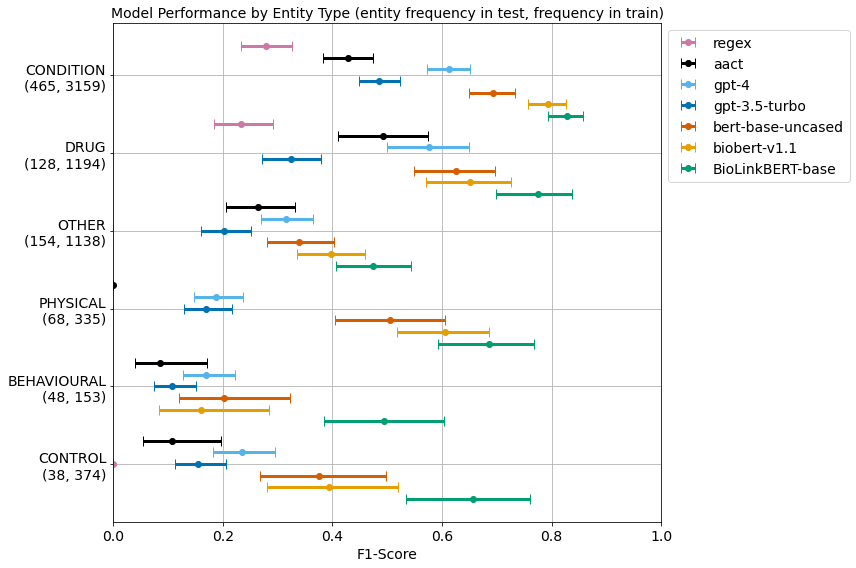

In [664]:
colors = {
    'BioLinkBERT-base': '#009E73',                    # Reddisch Purple
    'biobert-v1.1': '#E69F00',            # Orange
    'bert-base-uncased': '#D55E00',       # Vermillion
    'gpt-3.5-turbo': '#0072B2',           # Bluish Green
    'gpt-4': '#56B4E9',                   # Sky Blue
    'aact': '#000000',        # Black
    'regex': '#CC79A7'
    
}

results = results_f1_majority

# Predefined order of entity types
entity_order = ['control', 'behavioural', 'physical', 'other','drug','condition']

#entity_order = ['condition', 'drug', 'other', 'physical', 'behavioural', 'radiotherapy', 'surgical', 'control']

fig, ax = plt.subplots(figsize=(12, 8))
model_spacing = 0.15  # Spacing between models within the same entity type
entity_spacing = 0.5  # Additional spacing between different entity types

# Iterate over each entity type in the predefined order
for i, entity_type in enumerate(entity_order):
    model_index = 0  # Reset model index for each entity type
    if entity_type in results:
        num_models = len(results[entity_type])
        for model_name, data in results[entity_type].items():
            center = data[0][1]
            lower, upper = data[0][0], data[0][2]
            model_name = model_name.split("_")[1]
            color = colors[model_name]
            
            # Plot
            y_position = i + (model_index - num_models / 2) * model_spacing
            ax.errorbar(center, y_position, xerr=[[center - lower], [upper - center]],elinewidth = 3, fmt='o', color=color, capsize=5, label=model_name if i == 0 else "")
            #if center == 0: 
            #    ax.text(center, y_position, f"{center:.0f}", ha='center', va='bottom')
            #else:
            #    ax.text(center, y_position, f"{center:.2f}", ha='center', va='bottom')
            model_index += 1  
            
                  
# Setting the y-ticks according to the new entity order
ax.set_yticks(np.arange(len(entity_order)))
#ax.set_yticklabels(entity_order, fontsize=14)
ax.set_yticklabels(entity_labels, fontsize=14)


ax.set_xlabel('F1-Score', fontsize=14)
ax.set_title('Model Performance by Entity Type (entity frequency in test, frequency in train)', fontsize=14)
ax.grid(True)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlim([0, 1])

# Creating a legend that doesn't repeat labels
handles, labels = plt.gca().get_legend_handles_labels()
# Add 'regex' to the legend
handles.append(ax.errorbar(0, 0, xerr=[[0], [0]], color=colors['regex'], fmt='o', elinewidth = 3, capsize=5, label='regex'))
labels.append('regex')
# Reverse handles and labels
handles = handles[::-1]
labels = labels[::-1]
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14, bbox_to_anchor=(1, 1))

#ax.legend(by_label.values(), by_label.keys(), loc='upper left', fontsize=14)

plt.tight_layout()
plt.savefig("./evaluations/plots/rebuttal_all_entities_performance.pdf")
plt.show()